In [50]:
import pickle as pkl
from astropy.cosmology import Planck18
import numpy as np
from scipy.special import erfc
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt

In [51]:
with open('train_preprocessed.pkl', 'rb') as f:
    data = pkl.load(f)

In [52]:
def fluxToMag(f):
    m  = -2.5 * np.log10(f)
    return m

def magToFlux(m):
    f = 10**(-0.4*m)
    return f

def fluxToMagErr(f, df):
    dm = np.abs(2.5 / np.log(10) * df / f)

    return dm

def magToFluxErr(m, dm):
    df = np.abs(dm * 10**(-0.4*m) * np.log(10)/-2.5)
    return df

mag_cache = {}
def distmodWithCache(z):
    if z not in mag_cache:
        dmod = Planck18.distmod(z).value
        mag_cache[z] = dmod
    return mag_cache[z]

def correctMag(m, z):
    dmod = distmodWithCache(z)
    return m - dmod

def correctMagErr(merr, z, zerr):
    d_upper = distmodWithCache(z+zerr)
    d_lower = distmodWithCache(z-zerr)

    d_err = np.abs(d_upper - d_lower)/2
    return np.sqrt(merr**2+d_err**2)

In [53]:
def weightedMean(data, weights, dates, obs_date, tolerance, flux = True):
    #expects: data = array of means, weights = array of std. devs
    #computes the weighted mean with weight = 1/var^2

    if(flux):
        #convert everything to flux first
        weights = [magToFluxErr(data[i], weights[i]) for i in range(len(data))]
        data = [magToFlux(i) for i in data]
    
    sum = 0
    sum_weights = 0
    
    for i in range(len(data)):
        if(np.abs(dates[i] - obs_date) < tolerance):
            weight = 1 / (weights[i]**2)
            sum_weights += weight

            sum += weight * data[i]

    if sum_weights == 0:
        return None, None
    
    wmean = sum/sum_weights
    wmean_err = np.sqrt(1/sum_weights)

    if(flux):
        #convert back to magnitude
        wmean_err = fluxToMagErr(wmean, wmean_err)
        wmean = fluxToMag(wmean)

    return wmean, wmean_err

In [5]:
# mags = []
# magerr = []
# z = []

# for obs in tqdm(data):
#     if(len(obs["g"]) > 0):
#         mag, error = weightedMean(obs["g"]["mag"], obs["g"]["magerr"], obs["g"]["hmjd"], obs["desi_date"], float("inf"))
#         z.append(obs["z"])
#         mags.append(mag)
#         magerr.append(error)
# mags = np.asarray(mags)
# magerr = np.asarray(magerr)
# z = np.asarray(z)

In [6]:
# with open('g_mags.npy', 'wb') as f:
#     np.save(f, mags)
    
# with open('g_magerr.npy', 'wb') as f:
#     np.save(f, magerr)
    
# with open('g_z.npy', 'wb') as f:
#     np.save(f, z)

In [54]:
mags=np.load('g_mags.npy')
magerr=np.load('g_magerr.npy')
z =np.load('g_z.npy')

In [55]:
mag_cache = {}
def distmodWithCache(z):
    if z not in mag_cache:
        dmod = Planck18.distmod(z).value
        mag_cache[z] = dmod
    return mag_cache[z]

def make_likelihood_func(mags, magerr, z, kcorr, mag_lim):
    mags = np.asarray(mags)
    margerr = np.asarray(magerr)[mags < mag_lim]
    magerr_square = np.square(magerr)[mags < mag_lim]
    kcorr = np.asarray(kcorr)[mags < mag_lim]
    z = np.asarray(z)[mags < mag_lim]
    mags = mags[mags < mag_lim]

    distmod = np.asarray([distmodWithCache(i) for i in z])
    
    mlim_diff = np.subtract(mag_lim, mags)
    def get_ll(params):
        int_disp = params[0]
        true_mag =params[1]
        
        tot_err = np.sqrt(np.add(magerr_square, int_disp**2))
        sq_devs = np.square(np.subtract(mags, np.add(np.add(distmod, true_mag), kcorr)))
        #calculate the final terms
        term1 = np.sum(np.log(np.multiply(2*np.pi, tot_err)))*(1/2)
        
        term2 = (1/2)*np.sum(np.divide(sq_devs, tot_err))
        
        term3 = (1/2) * np.divide(mlim_diff, np.sqrt(np.multiply(tot_err, 2)))
        term3 = 1* np.sum(np.log(np.multiply(0.5, erfc(term3))))

        
        return -1 * (term1+term2+term3)
    
    return get_ll
        

In [117]:
k_g=np.load('/global/u1/z/zhaozhon/k-correction/k_g.npy')
apr_mag_g=np.load('/global/u1/z/zhaozhon/task/apr_mag_g.npy')
magerr_g_1=np.load('/global/u1/z/zhaozhon/task/magerr_g_1.npy')
z_g = np.load('/global/u1/z/zhaozhon/task/z_g.npy')
index_g=np.load('/global/u1/z/zhaozhon/k-correction/index_g.npy')

In [118]:
len(z_g[index_g])

22961

In [58]:
ll_func = make_likelihood_func(mags, magerr, z, np.zeros(len(mags)), 22)

In [62]:
out = scipy.optimize.minimize(lambda x: - 1 *ll_func(x), x0 = (2, 20), method = 'Nelder-Mead')
print(out)

 final_simplex: (array([[  1.19815544, -24.40010478],
       [  1.19813757, -24.40009381],
       [  1.19814463, -24.40008772]]), array([445337.53085923, 445337.53088699, 445337.53091779]))
           fun: 445337.53085922706
       message: 'Optimization terminated successfully.'
          nfev: 119
           nit: 61
        status: 0
       success: True
             x: array([  1.19815544, -24.40010478])


In [65]:
import emcee
nwalkers = 5
ndim = 2
p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, ll_func)
sampler.run_mcmc(p0, 20000)

/tmp/ipykernel_8473/4215232475.py:31: RuntimeWarning: divide by zero encountered in log
  term3 = 1* np.sum(np.log(np.multiply(0.5, erfc(term3))))


State([[ 1.19891480e+00 -2.43989468e+01]
 [ 1.20065352e+00 -2.44000815e+01]
 [-5.05923380e-03 -2.43865668e+01]
 [ 2.56397510e-03 -2.43098620e+01]
 [ 5.13093346e-04 -2.43906855e+01]], log_prob=[-445338.01491119 -445338.44985982              inf              inf
              inf], blobs=None, random_state=('MT19937', array([3387498874, 3491495850, 2783836563, 2952493213, 2091431315,
       1918647187,  655008507, 3925930761, 1441581824, 3175670156,
       4063170332,  502373202, 2193015141, 1914106112, 2086630568,
       2549750526, 1848321153, 2555437117, 3677109969,  725287031,
       2575540146, 4209263111, 3896204150, 1070160111,    4919242,
       2522390043, 3065750604,  373474923, 1268834945, 2477916378,
        331860687, 1462007472, 2760513311, 2658755785,  548015035,
        842827265, 1568531701,  293894826, 2536146097, 1919639094,
        413442693, 2228395849,  344659887, 2534582838, 2931858878,
        694416987,  900781433, 1089947347,  455043869, 4238498124,
       13556

In [66]:
samples = sampler.get_chain(flat = True)
with open('chain.npy', 'wb') as f:
    np.save(f, samples)

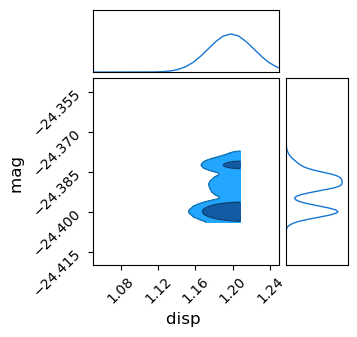

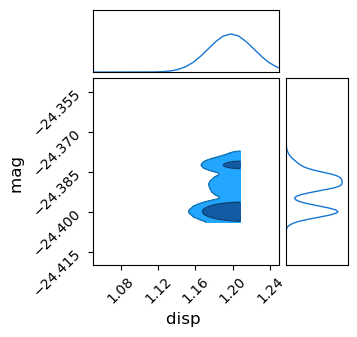

In [100]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
samples = sampler.get_chain(flat = True)
c.add_chain(samples[5000:,:], parameters=["disp", "mag"])
c.plotter.plot(extents = [[1.05,1.25],[-24.42, -24.35]])

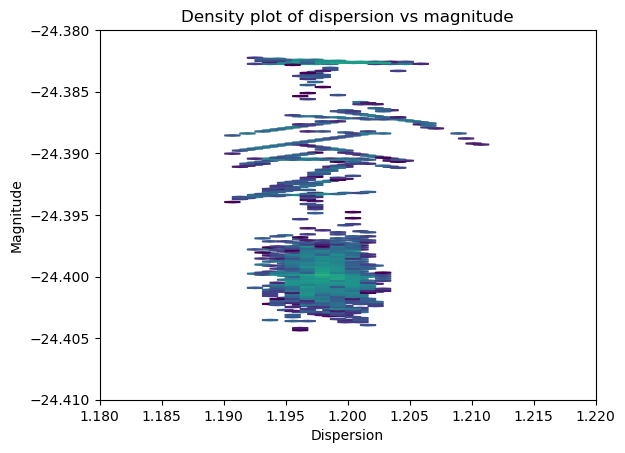

In [105]:
samples = sampler.get_chain(flat=True)
plt.hexbin(samples[10000:, 0], samples[10000:, 1], gridsize=1000, bins = "log")
plt.xlim(1.18, 1.22)
plt.ylim(-24.41, -24.38)
plt.xlabel("Dispersion")
plt.ylabel("Magnitude")
plt.title("Density plot of dispersion vs magnitude")
plt.show()

In [94]:
print(f"true mag: {np.mean(samples[5000:, 1])} +/- {np.std(samples[5000:, 1])}")
print(f"dispersion: {np.mean(samples[5000:, 0])} +/- {np.std(samples[5000:, 0])}")

true mag: -24.375832831826987 +/- 0.0334670552053889
dispersion: 0.47892422685420305 +/- 0.5873766827732244


In [16]:
tid_g=np.load('/global/u1/z/zhaozhon/k-correction/tid_g.npy')
k_g=np.load('/global/u1/z/zhaozhon/k-correction/k_g.npy')
index_g=np.load('/global/u1/z/zhaozhon/k-correction/index_g.npy')
abs_mag_g=np.load('/global/u1/z/zhaozhon/task/abs_mag_g.npy')
magerr_g_1=np.load('/global/u1/z/zhaozhon/task/magerr_g_1.npy')
z_g = np.load('/global/u1/z/zhaozhon/task/z_g.npy')
filtered_abs_mag_g = abs_mag_g[index_g]
filtered_magerr_g_1 = magerr_g_1[index_g]
filtered_z_g = z_g[index_g]
k_abs_mag_g = filtered_abs_mag_g - k_g

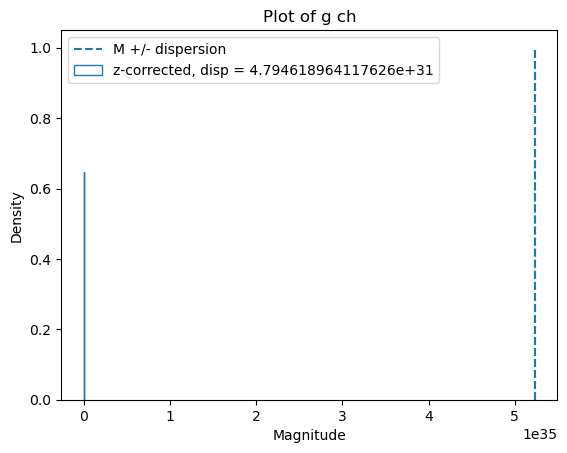

In [17]:
uncorr_d = round(out.x[0], 4)
plt.vlines(out.x[1], 0, 1, linestyles='dashed', label = "M +/- dispersion")
plt.vlines([out.x[1]- out.x[0], out.x[1]+ out.x[0]], 0, 1, linestyles='dotted')
plt.hist(filtered_abs_mag_g, density = True, range = [-36, -20], histtype = "step", bins=50, label = f"z-corrected, disp = {str(uncorr_d)}")
plt.title("Plot of g ch")
plt.ylabel("Density")
plt.xlabel("Magnitude")
plt.legend(loc = "upper left")
plt.show()